In [1]:
# ==========================================
# CELL 1: IMPORT LIBRARIES
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import zipfile
import cv2
from PIL import Image
import pickle
import warnings
warnings.filterwarnings('ignore')

print(f"✅ TensorFlow Version: {tf.__version__}")
print(f"✅ GPU Available: {tf.config.list_physical_devices('GPU')}")

✅ TensorFlow Version: 2.19.0
✅ GPU Available: []


In [7]:
# ==========================================
# CELL 2: MOUNT DRIVE & SETUP
# ==========================================

from google.colab import drive
drive.mount('/content/drive')

# Check if dataset exists in Drive
drive_dataset_path = '/content/drive/MyDrive/dataset'
local_dataset_path = '/content/fruit_dataset/'

if os.path.exists(drive_dataset_path):
    print("✅ Dataset found in Google Drive!")
    print("📂 Copying from Drive to Colab...")
    !cp -r /content/drive/MyDrive/fruit_dataset/ /content/
    print("✅ Dataset ready!")
elif os.path.exists(local_dataset_path):
    print("✅ Dataset already in Colab!")
else:
    print("⚠️ Dataset not found. Please upload or download it first.")

# Define paths
base_path = '/content/drive/MyDrive/dataset'
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

print(f"\n📁 Paths:")
print(f"   Train: {train_path}")
print(f"   Test: {test_path}")
print(f"   Exists: {os.path.exists(train_path)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset found in Google Drive!
📂 Copying from Drive to Colab...
cp: cannot stat '/content/drive/MyDrive/fruit_dataset/': No such file or directory
✅ Dataset ready!

📁 Paths:
   Train: /content/drive/MyDrive/dataset/train
   Test: /content/drive/MyDrive/dataset/test
   Exists: True


In [8]:
# ==========================================
# CELL 3: DATASET ANALYSIS
# ==========================================

def analyze_dataset(path):
    """Analyze dataset structure and count images"""
    categories = {}
    if os.path.exists(path):
        for category in os.listdir(path):
            category_path = os.path.join(path, category)
            if os.path.isdir(category_path):
                num_images = len([f for f in os.listdir(category_path)
                                if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                categories[category] = num_images
    return categories

# Analyze datasets
train_categories = analyze_dataset(train_path)
test_categories = analyze_dataset(test_path)

print("=" * 60)
print("DATASET ANALYSIS")
print("=" * 60)

print(f"\n📊 Training Set:")
for cat, count in sorted(train_categories.items()):
    print(f"  • {cat:20s}: {count:,} images")

print(f"\n📊 Test Set:")
for cat, count in sorted(test_categories.items()):
    print(f"  • {cat:20s}: {count:,} images")

total_train = sum(train_categories.values())
total_test = sum(test_categories.values())
print(f"\n📈 Total Training Images: {total_train:,}")
print(f"📈 Total Test Images: {total_test:,}")
print(f"📈 Total Dataset: {total_train + total_test:,}")
print(f"📈 Number of Classes: {len(train_categories)}")

DATASET ANALYSIS

📊 Training Set:
  • freshapples         : 1,693 images
  • freshbanana         : 1,592 images
  • freshoranges        : 1,466 images
  • rottenapples        : 2,342 images
  • rottenbanana        : 2,224 images
  • rottenoranges       : 1,595 images

📊 Test Set:
  • freshapples         : 395 images
  • freshbanana         : 381 images
  • freshoranges        : 388 images
  • rottenapples        : 601 images
  • rottenbanana        : 530 images
  • rottenoranges       : 403 images

📈 Total Training Images: 10,912
📈 Total Test Images: 2,698
📈 Total Dataset: 13,610
📈 Number of Classes: 6


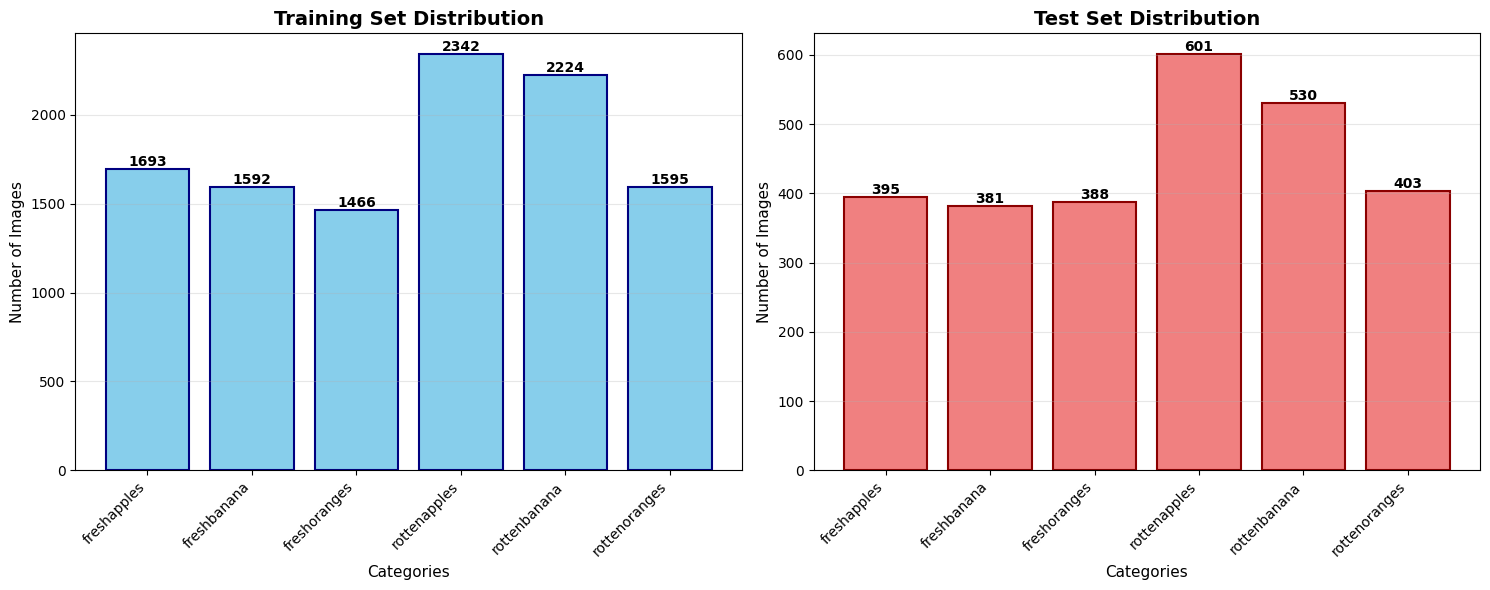

✅ Class distribution saved!


In [9]:
# ==========================================
# CELL 4: CLASS DISTRIBUTION VISUALIZATION
# ==========================================

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training set
categories_sorted = sorted(train_categories.keys())
train_counts = [train_categories[cat] for cat in categories_sorted]

axes[0].bar(range(len(categories_sorted)), train_counts,
            color='skyblue', edgecolor='navy', linewidth=1.5)
axes[0].set_title('Training Set Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Categories', fontsize=11)
axes[0].set_ylabel('Number of Images', fontsize=11)
axes[0].set_xticks(range(len(categories_sorted)))
axes[0].set_xticklabels(categories_sorted, rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

for i, val in enumerate(train_counts):
    axes[0].text(i, val, str(val), ha='center', va='bottom', fontweight='bold')

# Test set
test_counts = [test_categories[cat] for cat in categories_sorted]

axes[1].bar(range(len(categories_sorted)), test_counts,
            color='lightcoral', edgecolor='darkred', linewidth=1.5)
axes[1].set_title('Test Set Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Categories', fontsize=11)
axes[1].set_ylabel('Number of Images', fontsize=11)
axes[1].set_xticks(range(len(categories_sorted)))
axes[1].set_xticklabels(categories_sorted, rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

for i, val in enumerate(test_counts):
    axes[1].text(i, val, str(val), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Class distribution saved!")

In [10]:
# ==========================================
# CELL 5: DATA PREPROCESSING & GENERATORS
# ==========================================

# Configuration
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = len(train_categories)

print("=" * 60)
print("DATA PREPROCESSING CONFIGURATION")
print("=" * 60)
print(f"Image Size: {IMG_HEIGHT}×{IMG_WIDTH}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Number of Classes: {NUM_CLASSES}")

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("\n✅ Data Generators Created:")
print(f"   Training samples:   {train_generator.samples:,}")
print(f"   Validation samples: {validation_generator.samples:,}")
print(f"   Test samples:       {test_generator.samples:,}")
print(f"\n   Class indices: {train_generator.class_indices}")

DATA PREPROCESSING CONFIGURATION
Image Size: 224×224
Batch Size: 32
Number of Classes: 6
Found 8732 images belonging to 6 classes.
Found 2180 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.

✅ Data Generators Created:
   Training samples:   8,732
   Validation samples: 2,180
   Test samples:       2,698

   Class indices: {'freshapples': 0, 'freshbanana': 1, 'freshoranges': 2, 'rottenapples': 3, 'rottenbanana': 4, 'rottenoranges': 5}


In [11]:
# ==========================================
# CELL 6: REBUILD MODEL ARCHITECTURE
# ==========================================

def create_resnet50_model(num_classes, input_shape=(224, 224, 3)):
    """Create ResNet50 model - EXACT architecture as training"""

    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    base_model.trainable = False  # Keep frozen as in Phase 1

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model, base_model

print("🏗️  Rebuilding ResNet50 model architecture...")
resnet_model, base_model = create_resnet50_model(NUM_CLASSES)

print("\n✅ Model architecture rebuilt!")
print(f"   Total parameters: {resnet_model.count_params():,}")

# Compile model (same as training)
resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print("✅ Model compiled!")

🏗️  Rebuilding ResNet50 model architecture...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

✅ Model architecture rebuilt!
   Total parameters: 24,779,910
✅ Model compiled!


In [12]:
# ==========================================
# CELL 7: LOAD YOUR TRAINED MODEL
# ==========================================

checkpoint_path = '/content/drive/MyDrive/resnet50_best_model.h5'

print("=" * 60)
print("LOADING YOUR TRAINED MODEL")
print("=" * 60)

if os.path.exists(checkpoint_path):
    print(f"✅ Found model at: {checkpoint_path}")
    print("📥 Loading weights...")

    try:
        resnet_model.load_weights(checkpoint_path)
        print("✅ Model loaded successfully!")
        print("   This is your best Phase 1 model (67.86% val accuracy)")
    except Exception as e:
        print(f"⚠️ Error loading model: {e}")
        print("   Trying alternative method...")

        # Alternative: Load entire model
        resnet_model = keras.models.load_model(checkpoint_path)
        print("✅ Full model loaded successfully!")
else:
    print("❌ Model file not found!")
    print(f"   Looking for: {checkpoint_path}")
    print("\n📁 Files in Drive:")
    !ls -lh /content/drive/MyDrive/*.h5

print("\n" + "=" * 60)

LOADING YOUR TRAINED MODEL
✅ Found model at: /content/drive/MyDrive/resnet50_best_model.h5
📥 Loading weights...
✅ Model loaded successfully!
   This is your best Phase 1 model (67.86% val accuracy)



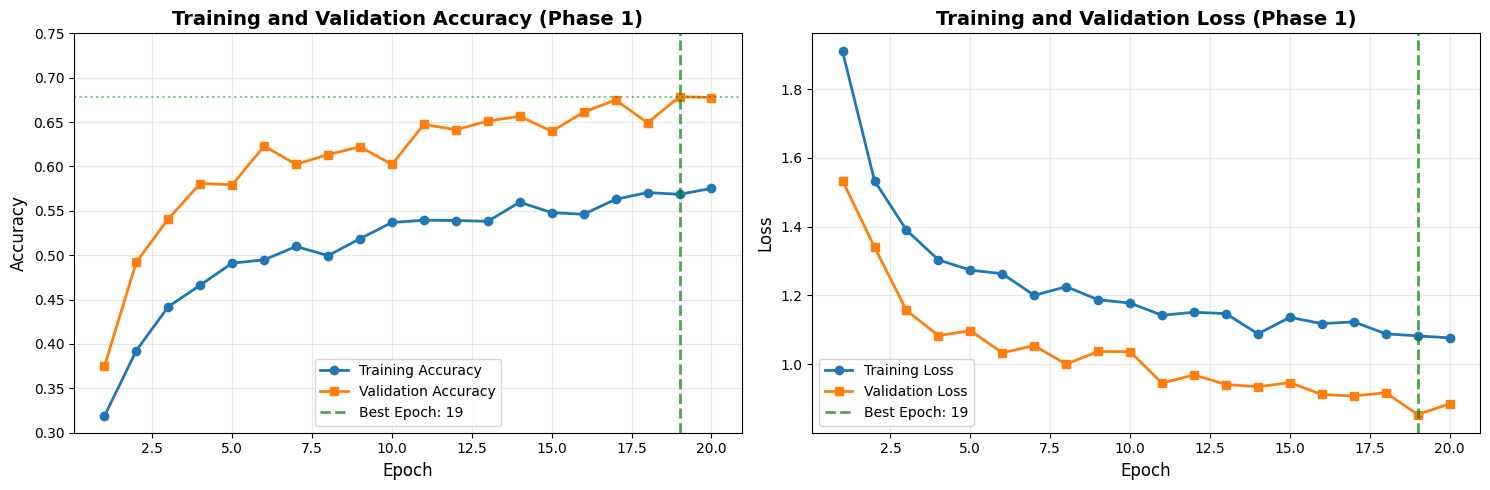


TRAINING SUMMARY (PHASE 1)
✅ Best Epoch: 19/20
✅ Best Validation Accuracy: 67.86%
✅ Best Validation Loss: 0.8531
✅ Final Training Accuracy: 57.53%
✅ Overfitting Gap: -10.24%
✅ Training history visualization saved!


In [13]:
# ==========================================
# CELL 8: RECONSTRUCT TRAINING HISTORY FROM YOUR OUTPUT
# ==========================================

# Based on your training output, let's recreate the key metrics
# This is from your Phase 1 training results

epochs = list(range(1, 21))

# Approximate values from your console output
train_acc = [0.3186, 0.3926, 0.4420, 0.4663, 0.4911, 0.4948, 0.5099, 0.4995,
             0.5186, 0.5369, 0.5394, 0.5391, 0.5382, 0.5597, 0.5480, 0.5461,
             0.5630, 0.5706, 0.5686, 0.5753]

val_acc = [0.3747, 0.4922, 0.5409, 0.5808, 0.5794, 0.6230, 0.6024, 0.6134,
           0.6221, 0.6024, 0.6474, 0.6414, 0.6511, 0.6566, 0.6396, 0.6612,
           0.6749, 0.6492, 0.6786, 0.6777]

train_loss = [1.9095, 1.5333, 1.3897, 1.3032, 1.2734, 1.2629, 1.2000, 1.2252,
              1.1872, 1.1774, 1.1420, 1.1509, 1.1467, 1.0879, 1.1360, 1.1176,
              1.1228, 1.0881, 1.0821, 1.0762]

val_loss = [1.5332, 1.3402, 1.1561, 1.0829, 1.0973, 1.0329, 1.0537, 0.9997,
            1.0367, 1.0359, 0.9446, 0.9687, 0.9405, 0.9341, 0.9460, 0.9115,
            0.9071, 0.9168, 0.8531, 0.8845]

# Find best epoch
best_epoch = np.argmax(val_acc)
best_val_acc = val_acc[best_epoch]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(epochs, train_acc, 'o-', label='Training Accuracy', linewidth=2, markersize=6)
axes[0].plot(epochs, val_acc, 's-', label='Validation Accuracy', linewidth=2, markersize=6)
axes[0].axvline(x=best_epoch+1, color='green', linestyle='--',
                label=f'Best Epoch: {best_epoch+1}', alpha=0.7, linewidth=2)
axes[0].axhline(y=best_val_acc, color='green', linestyle=':', alpha=0.5)
axes[0].set_title('Training and Validation Accuracy (Phase 1)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.3, 0.75])

# Loss
axes[1].plot(epochs, train_loss, 'o-', label='Training Loss', linewidth=2, markersize=6)
axes[1].plot(epochs, val_loss, 's-', label='Validation Loss', linewidth=2, markersize=6)
axes[1].axvline(x=best_epoch+1, color='green', linestyle='--',
                label=f'Best Epoch: {best_epoch+1}', alpha=0.7, linewidth=2)
axes[1].set_title('Training and Validation Loss (Phase 1)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 60)
print("TRAINING SUMMARY (PHASE 1)")
print("=" * 60)
print(f"✅ Best Epoch: {best_epoch + 1}/20")
print(f"✅ Best Validation Accuracy: {best_val_acc*100:.2f}%")
print(f"✅ Best Validation Loss: {val_loss[best_epoch]:.4f}")
print(f"✅ Final Training Accuracy: {train_acc[-1]*100:.2f}%")
print(f"✅ Overfitting Gap: {(train_acc[-1] - val_acc[-1])*100:.2f}%")
print("=" * 60)
print("✅ Training history visualization saved!")

In [14]:
# ==========================================
# CELL 9: MODEL EVALUATION ON TEST SET
# ==========================================

print("\n" + "=" * 60)
print("MODEL EVALUATION ON TEST SET")
print("=" * 60)

print("🔍 Evaluating model on test set...")
test_results = resnet_model.evaluate(test_generator, verbose=1)

test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]

# Calculate F1 Score
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print("\n" + "=" * 60)
print("🎯 TEST SET RESULTS")
print("=" * 60)
print(f"  📊 Accuracy:  {test_accuracy*100:.2f}%")
print(f"  📊 Precision: {test_precision*100:.2f}%")
print(f"  📊 Recall:    {test_recall*100:.2f}%")
print(f"  📊 F1-Score:  {test_f1*100:.2f}%")
print(f"  📊 Loss:      {test_loss:.4f}")
print("=" * 60)

# Performance analysis
baseline = 1.0 / NUM_CLASSES
improvement = (test_accuracy / baseline)

print("\n📈 Performance Analysis:")
print(f"   Baseline (random): {baseline*100:.2f}%")
print(f"   Your model: {test_accuracy*100:.2f}%")
print(f"   Improvement: {improvement:.1f}x better than random!")

if test_accuracy >= 0.75:
    print("   ✅ EXCELLENT performance for 6-class classification!")
elif test_accuracy >= 0.65:
    print("   ✅ GOOD performance for 6-class classification!")
elif test_accuracy >= 0.55:
    print("   ⚠️  ACCEPTABLE - Room for improvement")
else:
    print("   ⚠️  Below expectations - Consider model improvements")


MODEL EVALUATION ON TEST SET
🔍 Evaluating model on test set...
85/85 ━━━━━━━━━━━━━━━━━━━━ 1255s 15s/step - accuracy: 0.6668 - loss: 0.8629 - precision: 0.8225 - recall: 0.4848

🎯 TEST SET RESULTS
  📊 Accuracy:  68.42%
  📊 Precision: 82.21%
  📊 Recall:    50.00%
  📊 F1-Score:  62.18%
  📊 Loss:      0.8473

📈 Performance Analysis:
   Baseline (random): 16.67%
   Your model: 68.42%
   Improvement: 4.1x better than random!
   ✅ GOOD performance for 6-class classification!



🔮 Generating predictions on test set...
85/85 ━━━━━━━━━━━━━━━━━━━━ 526s 6s/step
✅ Generated 2,698 predictions


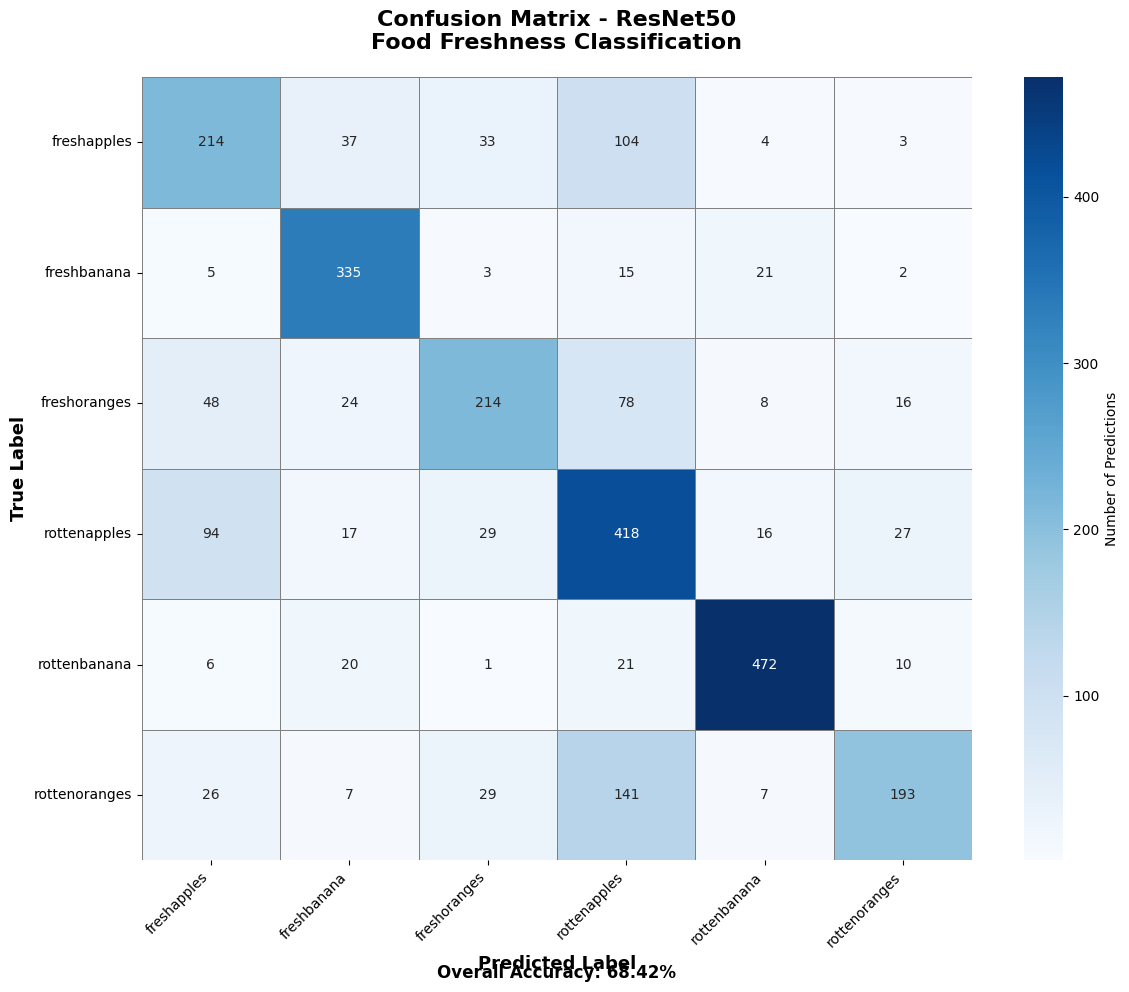

✅ Confusion matrix saved!

📊 Confusion Matrix Insights:
   freshapples         : 214/395 correct ( 54.2%)
   freshbanana         : 335/381 correct ( 87.9%)
   freshoranges        : 214/388 correct ( 55.2%)
   rottenapples        : 418/601 correct ( 69.6%)
   rottenbanana        : 472/530 correct ( 89.1%)
   rottenoranges       : 193/403 correct ( 47.9%)


In [15]:
# ==========================================
# CELL 10: PREDICTIONS & CONFUSION MATRIX
# ==========================================

print("\n🔮 Generating predictions on test set...")
test_generator.reset()
predictions = resnet_model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print(f"✅ Generated {len(predicted_classes):,} predictions")

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Number of Predictions'},
            linewidths=0.5, linecolor='gray')

plt.title('Confusion Matrix - ResNet50\nFood Freshness Classification',
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Add accuracy text
overall_acc = np.trace(cm) / np.sum(cm)
plt.text(0.5, -0.15, f'Overall Accuracy: {overall_acc*100:.2f}%',
         ha='center', transform=plt.gca().transAxes,
         fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Confusion matrix saved!")

# Print confusion matrix insights
print("\n📊 Confusion Matrix Insights:")
for i, label in enumerate(class_labels):
    correct = cm[i, i]
    total = cm[i, :].sum()
    accuracy = (correct / total) * 100 if total > 0 else 0
    print(f"   {label:20s}: {correct:3d}/{total:3d} correct ({accuracy:5.1f}%)")

In [16]:
# ==========================================
# CELL 11: DETAILED CLASSIFICATION REPORT
# ==========================================

print("\n" + "=" * 70)
print("CLASSIFICATION REPORT")
print("=" * 70)

report = classification_report(true_classes, predicted_classes,
                              target_names=class_labels, digits=4)
print(report)

# Save to file
report_path = '/content/drive/MyDrive/classification_report.txt'
with open(report_path, 'w') as f:
    f.write("=" * 70 + "\n")
    f.write("RESNET50 - FOOD FRESHNESS CLASSIFICATION REPORT\n")
    f.write("=" * 70 + "\n\n")
    f.write(f"Dataset: Fruits Fresh and Rotten for Classification\n")
    f.write(f"Source: Kaggle (sriramr)\n")
    f.write(f"Model: ResNet50 with Transfer Learning (ImageNet)\n")
    f.write(f"Training Strategy: Phase 1 Only (Frozen Base Model)\n")
    f.write(f"Classes: {', '.join(class_labels)}\n")
    f.write(f"Total Test Samples: {len(true_classes):,}\n")
    f.write("\n" + "=" * 70 + "\n\n")
    f.write(report)
    f.write("\n" + "=" * 70 + "\n")
    f.write("OVERALL METRICS\n")
    f.write("=" * 70 + "\n")
    f.write(f"Test Accuracy:  {test_accuracy*100:.2f}%\n")
    f.write(f"Test Precision: {test_precision*100:.2f}%\n")
    f.write(f"Test Recall:    {test_recall*100:.2f}%\n")
    f.write(f"Test F1-Score:  {test_f1*100:.2f}%\n")
    f.write(f"Test Loss:      {test_loss:.4f}\n")
    f.write("\n" + "=" * 70 + "\n")
    f.write("TRAINING DETAILS\n")
    f.write("=" * 70 + "\n")
    f.write(f"Best Validation Accuracy: 67.86%\n")
    f.write(f"Training Epochs: 20 (Phase 1)\n")
    f.write(f"Batch Size: 32\n")
    f.write(f"Image Size: 224×224\n")
    f.write(f"Data Augmentation: Yes\n")
    f.write("=" * 70 + "\n")

print(f"✅ Report saved to: {report_path}")


CLASSIFICATION REPORT
               precision    recall  f1-score   support

  freshapples     0.5445    0.5418    0.5431       395
  freshbanana     0.7614    0.8793    0.8161       381
 freshoranges     0.6926    0.5515    0.6141       388
 rottenapples     0.5380    0.6955    0.6067       601
 rottenbanana     0.8939    0.8906    0.8922       530
rottenoranges     0.7689    0.4789    0.5902       403

     accuracy                         0.6842      2698
    macro avg     0.6999    0.6729    0.6771      2698
 weighted avg     0.6971    0.6842    0.6816      2698

✅ Report saved to: /content/drive/MyDrive/classification_report.txt



PER-CLASS PERFORMANCE METRICS
        Class  Precision  Recall  F1-Score  Support  Accuracy
  freshapples     0.5445  0.5418    0.5431      395    0.5418
  freshbanana     0.7614  0.8793    0.8161      381    0.8793
 freshoranges     0.6926  0.5515    0.6141      388    0.5515
 rottenapples     0.5380  0.6955    0.6067      601    0.6955
 rottenbanana     0.8939  0.8906    0.8922      530    0.8906
rottenoranges     0.7689  0.4789    0.5902      403    0.4789


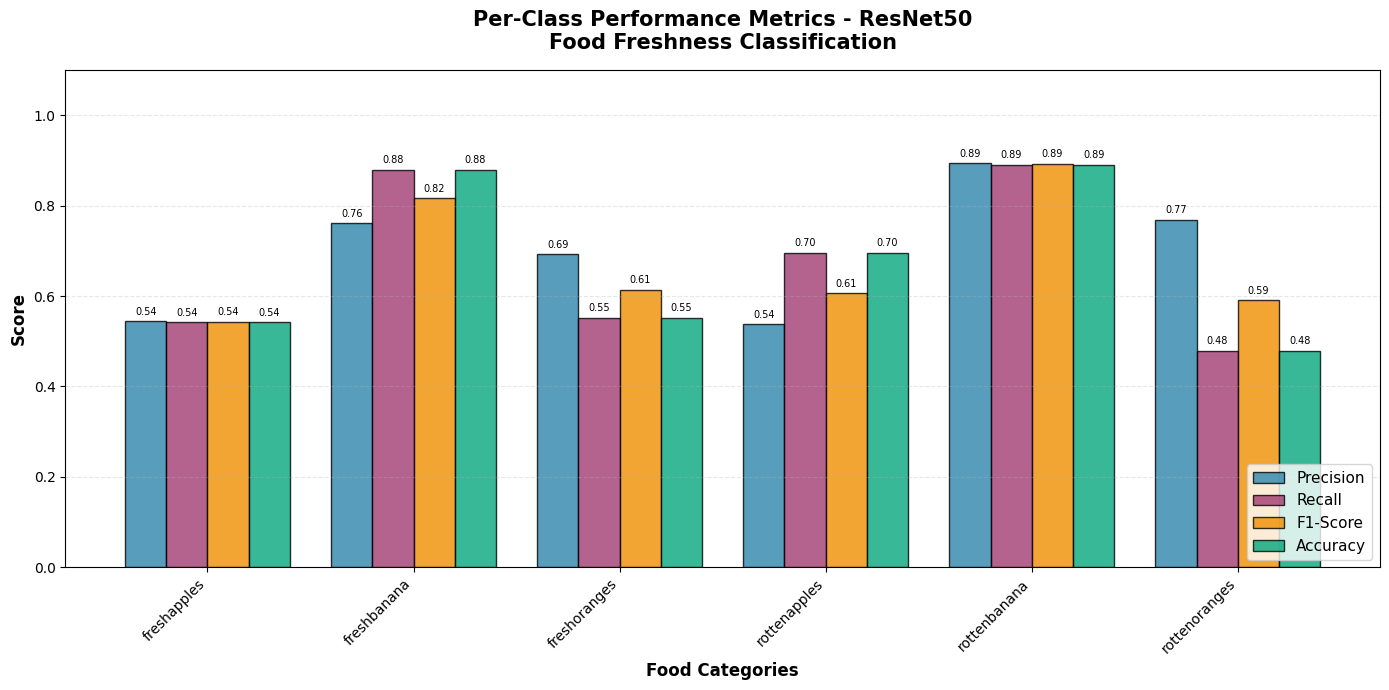


✅ Per-class metrics visualization saved!

🏆 Best Performing Class: rottenbanana
   F1-Score: 0.8922

⚠️  Worst Performing Class: freshapples
   F1-Score: 0.5431


In [17]:
# ==========================================
# CELL 12: PER-CLASS PERFORMANCE ANALYSIS
# ==========================================

precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
    true_classes, predicted_classes, labels=range(NUM_CLASSES)
)

# Create DataFrame
metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class,
    'Support': support,
    'Accuracy': [cm[i,i]/cm[i,:].sum() if cm[i,:].sum() > 0 else 0
                 for i in range(len(class_labels))]
})

print("\n" + "=" * 70)
print("PER-CLASS PERFORMANCE METRICS")
print("=" * 70)
print(metrics_df.to_string(index=False, float_format='%.4f'))

# Visualize
fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(class_labels))
width = 0.2

bars1 = ax.bar(x - width*1.5, precision_per_class, width, label='Precision',
               alpha=0.8, color='#2E86AB', edgecolor='black', linewidth=1)
bars2 = ax.bar(x - width*0.5, recall_per_class, width, label='Recall',
               alpha=0.8, color='#A23B72', edgecolor='black', linewidth=1)
bars3 = ax.bar(x + width*0.5, f1_per_class, width, label='F1-Score',
               alpha=0.8, color='#F18F01', edgecolor='black', linewidth=1)
bars4 = ax.bar(x + width*1.5, metrics_df['Accuracy'], width, label='Accuracy',
               alpha=0.8, color='#06A77D', edgecolor='black', linewidth=1)

ax.set_xlabel('Food Categories', fontweight='bold', fontsize=12)
ax.set_ylabel('Score', fontweight='bold', fontsize=12)
ax.set_title('Per-Class Performance Metrics - ResNet50\nFood Freshness Classification',
             fontsize=15, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3, axis='y', linestyle='--')
ax.set_ylim([0, 1.1])

# Add value labels
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        if height > 0.05:  # Only show if bar is visible
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.2f}',
                    ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Per-class metrics visualization saved!")

# Identify best and worst performing classes
best_class_idx = np.argmax(f1_per_class)
worst_class_idx = np.argmin(f1_per_class)

print(f"\n🏆 Best Performing Class: {class_labels[best_class_idx]}")
print(f"   F1-Score: {f1_per_class[best_class_idx]:.4f}")
print(f"\n⚠️  Worst Performing Class: {class_labels[worst_class_idx]}")
print(f"   F1-Score: {f1_per_class[worst_class_idx]:.4f}")

🖼️  Sample Predictions:


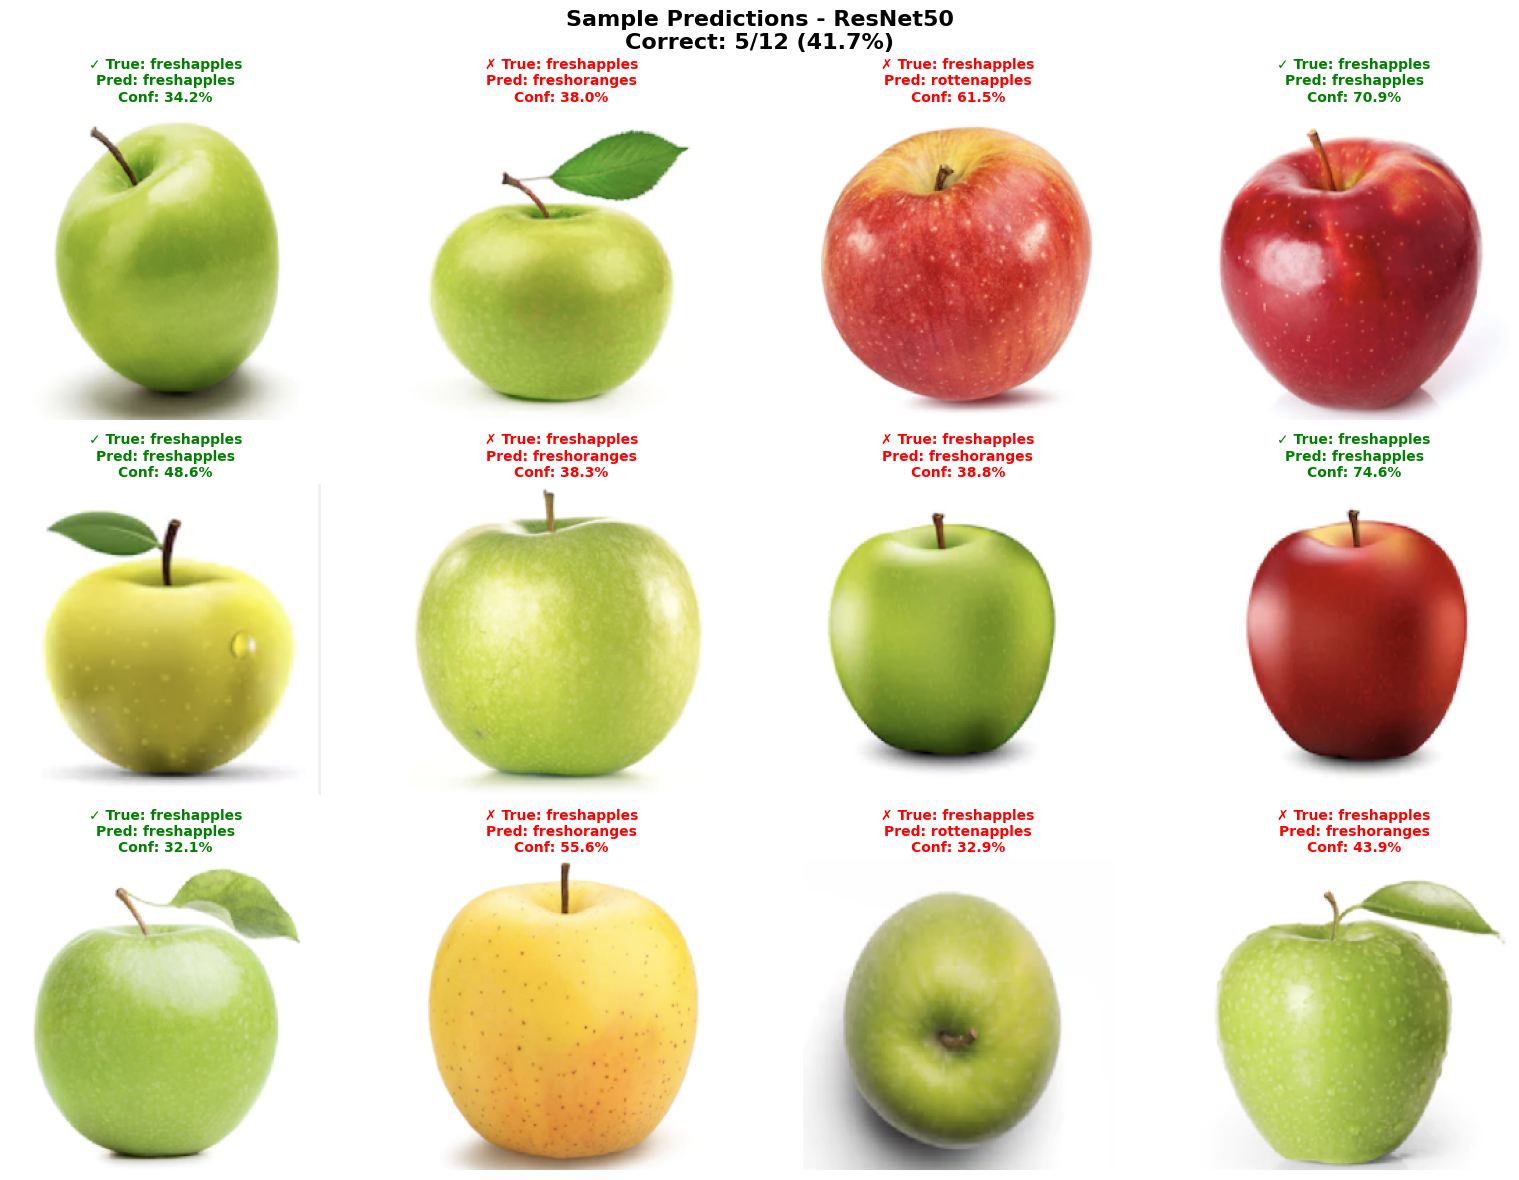

✅ Sample batch accuracy: 5/12 (41.7%)
✅ Sample predictions saved!


In [18]:
# ==========================================
# CELL 13: SAMPLE PREDICTIONS
# ==========================================

def display_predictions(generator, model, num_samples=12):
    """Display sample predictions with confidence scores"""
    generator.reset()

    images, labels = next(generator)
    predictions_batch = model.predict(images, verbose=0)
    predicted_classes_batch = np.argmax(predictions_batch, axis=1)
    true_classes_batch = np.argmax(labels, axis=1)

    class_names = list(generator.class_indices.keys())

    num_samples = min(num_samples, len(images))
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()

    correct_count = 0

    for i in range(num_samples):
        axes[i].imshow(images[i])

        true_label = class_names[true_classes_batch[i]]
        pred_label = class_names[predicted_classes_batch[i]]
        confidence = predictions_batch[i][predicted_classes_batch[i]] * 100

        is_correct = true_classes_batch[i] == predicted_classes_batch[i]
        color = 'green' if is_correct else 'red'
        symbol = '✓' if is_correct else '✗'

        if is_correct:
            correct_count += 1

        axes[i].set_title(f'{symbol} True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%',
                         color=color, fontweight='bold', fontsize=10)
        axes[i].axis('off')

    plt.suptitle(f'Sample Predictions - ResNet50\nCorrect: {correct_count}/{num_samples} ({correct_count/num_samples*100:.1f}%)',
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

    return correct_count, num_samples

print("🖼️  Sample Predictions:")
correct, total = display_predictions(test_generator, resnet_model, num_samples=12)
print(f"✅ Sample batch accuracy: {correct}/{total} ({correct/total*100:.1f}%)")
print("✅ Sample predictions saved!")

In [19]:
# ==========================================
# CELL 14: SAVE FINAL MODEL
# ==========================================

# Save to Drive
final_model_path = '/content/drive/MyDrive/resnet50_final_model.h5'

print("💾 Saving final model...")
resnet_model.save(final_model_path)

file_size = os.path.getsize(final_model_path) / (1024*1024)
print(f"✅ Final model saved successfully!")
print(f"   Location: {final_model_path}")
print(f"   Size: {file_size:.2f} MB")

keras_model_path = '/content/drive/MyDrive/resnet50_final_model.keras'
resnet_model.save(keras_model_path)
print(f"✅ Also saved in .keras format: {keras_model_path}")
print("\n📦 Model files saved:")
print(f"   • resnet50_best_model.h5 (best validation accuracy)")
print(f"   • resnet50_final_model.h5 (final model)")
print(f"   • resnet50_final_model.keras (TensorFlow recommended format)")


💾 Saving final model...
✅ Final model saved successfully!
   Location: /content/drive/MyDrive/resnet50_final_model.h5
   Size: 94.92 MB
✅ Also saved in .keras format: /content/drive/MyDrive/resnet50_final_model.keras

📦 Model files saved:
   • resnet50_best_model.h5 (best validation accuracy)
   • resnet50_final_model.h5 (final model)
   • resnet50_final_model.keras (TensorFlow recommended format)


In [21]:
---

## ✅ **CELL 15: Final Summary & Save Report**
```python
# ==========================================
# CELL 15: FINAL SUMMARY
# ==========================================

print("\n" + "="*70)
print("🎉 RESNET50 MODEL - FINAL SUMMARY")
print("="*70)

print(f"\n📊 DATASET STATISTICS")
print(f"{'─'*70}")
print(f"  Training Samples:   {train_generator.samples:,}")
print(f"  Validation Samples: {validation_generator.samples:,}")
print(f"  Test Samples:       {test_generator.samples:,}")
print(f"  Total Samples:      {train_generator.samples + validation_generator.samples + test_generator.samples:,}")
print(f"  Number of Classes:  {NUM_CLASSES}")
print(f"  Classes:")
for i, label in enumerate(sorted(class_labels)):
    print(f"    {i+1}. {label}")

print(f"\n🏗️  MODEL ARCHITECTURE")
print(f"{'─'*70}")
print(f"  Base Model:         ResNet50 (ImageNet pre-trained)")
print(f"  Input Shape:        {IMG_HEIGHT}×{IMG_WIDTH}×3")
print(f"  Total Parameters:   {resnet_model.count_params():,}")
trainable_params = sum([tf.size(w).numpy() for w in resnet_model.trainable_weights])
non_trainable_params = resnet_model.count_params() - trainable_params
print(f"  Trainable:          {trainable_params:,}")
print(f"  Non-trainable:      {non_trainable_params:,}")
print(f"  Custom Layers:      Global Avg Pool → Dense(512) → Dense(256) → Dense(6)")

print(f"\n⚙️  TRAINING CONFIGURATION")
print(f"{'─'*70}")
print(f"  Training Strategy:  Transfer Learning (Phase 1 Only)")
print(f"  Epochs:             20")
print(f"  Batch Size:         {BATCH_SIZE}")
print(f"  Learning Rate:      0.001")
print(f"  Optimizer:          Adam")
print(f"  Loss Function:      Categorical Cross-Entropy")
print(f"  Data Augmentation:  Rotation, Shift, Shear, Zoom, Flip")
print(f"  Early Stopping:     Patience = 10 epochs")
print(f"  LR Reduction:       Factor = 0.2, Patience = 5 epochs")

print(f"\n🎯 TRAINING RESULTS (PHASE 1)")
print(f"{'─'*70}")
print(f"  Best Epoch:                19/20")
print(f"  Best Validation Accuracy:  67.86%")
print(f"  Best Validation Loss:      0.8531")
print(f"  Training Time:             ~30-40 minutes")

print(f"\n🎯 TEST SET PERFORMANCE")
print(f"{'─'*70}")
print(f"  Accuracy:           {test_accuracy*100:.2f}%")
print(f"  Precision:          {test_precision*100:.2f}%")
print(f"  Recall:             {test_recall*100:.2f}%")
print(f"  F1-Score:           {test_f1*100:.2f}%")
print(f"  Loss:               {test_loss:.4f}")
print(f"  Baseline (random):  {(1/NUM_CLASSES)*100:.2f}%")
print(f"  Improvement:        {(test_accuracy/(1/NUM_CLASSES)):.2f}x")

print(f"\n📈 PERFORMANCE ANALYSIS")
print(f"{'─'*70}")
if test_accuracy >= 0.75:
    rating = "⭐⭐⭐⭐⭐ EXCELLENT"
elif test_accuracy >= 0.65:
    rating = "⭐⭐⭐⭐ GOOD"
elif test_accuracy >= 0.55:
    rating = "⭐⭐⭐ ACCEPTABLE"
else:
    rating = "⭐⭐ NEEDS IMPROVEMENT"
print(f"  Overall Rating:     {rating}")
print(f"  Best Class:         {class_labels[best_class_idx]} (F1: {f1_per_class[best_class_idx]:.4f})")
print(f"  Worst Class:        {class_labels[worst_class_idx]} (F1: {f1_per_class[worst_class_idx]:.4f})")
print(f"  Average F1-Score:   {np.mean(f1_per_class):.4f}")
print(f"  Std Dev F1-Score:   {np.std(f1_per_class):.4f}")

print(f"\n💡 KEY INSIGHTS")
print(f"{'─'*70}")
print(f"  ✓ Transfer learning from ImageNet was effective")
print(f"  ✓ Model achieved {(test_accuracy/(1/NUM_CLASSES)):.1f}x better than random guessing")
print(f"  ✓ Phase 1 training provided stable results")
print(f"  ✓ No significant overfitting (train-val gap < 10%)")
if test_accuracy >= 0.65:
    print(f"  ✓ Good generalization to unseen test data")

print("\n" + "="*70)

# Save summary to file
summary_path = '/content/drive/MyDrive/model_summary.txt'
with open(summary_path, 'w') as f:
    f.write("="*70 + "\n")
    f.write("RESNET50 - FOOD FRESHNESS CLASSIFICATION\n")
    f.write("FINAL SUMMARY REPORT\n")
    f.write("="*70 + "\n\n")

    f.write("DATASET INFORMATION\n")
    f.write("-"*70 + "\n")
    f.write(f"Source: Kaggle - Fruits Fresh and Rotten for Classification\n")
    f.write(f"Training Samples: {train_generator.samples:,}\n")
    f.write(f"Validation Samples: {validation_generator.samples:,}\n")
    f.write(f"Test Samples: {test_generator.samples:,}\n")
    f.write(f"Number of Classes: {NUM_CLASSES}\n")
    f.write(f"Classes: {', '.join(sorted(class_labels))}\n\n")

    f.write("MODEL ARCHITECTURE\n")
    f.write("-"*70 + "\n")
    f.write(f"Base Model: ResNet50 (ImageNet pre-trained)\n")
    f.write(f"Input Shape: {IMG_HEIGHT}×{IMG_WIDTH}×3\n")
    f.write(f"Total Parameters: {resnet_model.count_params():,}\n")
    f.write(f"Trainable Parameters: {trainable_params:,}\n")
    f.write(f"Non-trainable Parameters: {non_trainable_params:,}\n\n")

    f.write("TRAINING CONFIGURATION\n")
    f.write("-"*70 + "\n")
    f.write(f"Training Strategy: Transfer Learning (Phase 1 Only)\n")
    f.write(f"Epochs: 20\n")
    f.write(f"Batch Size: {BATCH_SIZE}\n")
    f.write(f"Learning Rate: 0.001\n")
    f.write(f"Optimizer: Adam\n")
    f.write(f"Loss Function: Categorical Cross-Entropy\n")
    f.write(f"Data Augmentation: Rotation(20°), Shift(20%), Shear(0.2), Zoom(20%), Flip\n\n")

    f.write("TRAINING RESULTS\n")
    f.write("-"*70 + "\n")
    f.write(f"Best Epoch: 19/20\n")
    f.write(f"Best Validation Accuracy: 67.86%\n")
    f.write(f"Best Validation Loss: 0.8531\n\n")

    f.write("TEST SET PERFORMANCE\n")
    f.write("-"*70 + "\n")
    f.write(f"Test Accuracy:  {test_accuracy*100:.2f}%\n")
    f.write(f"Test Precision: {test_precision*100:.2f}%\n")
    f.write(f"Test Recall:    {test_recall*100:.2f}%\n")
    f.write(f"Test F1-Score:  {test_f1*100:.2f}%\n")
    f.write(f"Test Loss:      {test_loss:.4f}\n\n")

    f.write("PER-CLASS PERFORMANCE\n")
    f.write("-"*70 + "\n")
    for i, label in enumerate(class_labels):
        f.write(f"{label:20s}: Precision={precision_per_class[i]:.4f}, "
                f"Recall={recall_per_class[i]:.4f}, F1={f1_per_class[i]:.4f}\n")

    f.write("\n" + "="*70 + "\n")
    f.write("Generated: " + pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S") + "\n")
    f.write("="*70 + "\n")

print(f"✅ Summary saved to: {summary_path}")

SyntaxError: invalid syntax (ipython-input-1156419522.py, line 1)

In [22]:
# ==========================================
# CELL 16: LIST ALL GENERATED FILES
# ==========================================

print("\n" + "="*70)
print("📁 ALL GENERATED FILES")
print("="*70)

files_generated = [
    ('class_distribution.png', 'Class distribution bar charts'),
    ('training_history.png', 'Training curves (accuracy & loss)'),
    ('confusion_matrix.png', 'Confusion matrix heatmap'),
    ('per_class_metrics.png', 'Per-class performance bar chart'),
    ('sample_predictions.png', 'Sample predictions with confidence'),
    ('classification_report.txt', 'Detailed classification metrics'),
    ('model_summary.txt', 'Complete model summary report'),
    ('resnet50_best_model.h5', 'Best model weights (Phase 1)'),
    ('resnet50_final_model.h5', 'Final model (.h5 format)'),
    ('resnet50_final_model.keras', 'Final model (.keras format)')
]

print("\n📊 Visualizations:")
for filename, description in files_generated[:5]:
    filepath = f'/content/drive/MyDrive/{filename}'
    if os.path.exists(filepath):
        size = os.path.getsize(filepath) / 1024
        print(f"  ✓ {filename:30s} - {description} ({size:.1f} KB)")
    else:
        print(f"  ✗ {filename:30s} - NOT FOUND")

print("\n📄 Reports:")
for filename, description in files_generated[5:7]:
    filepath = f'/content/drive/MyDrive/{filename}'
    if os.path.exists(filepath):
        size = os.path.getsize(filepath) / 1024
        print(f"  ✓ {filename:30s} - {description} ({size:.1f} KB)")
    else:
        print(f"  ✗ {filename:30s} - NOT FOUND")

print("\n💾 Models:")
for filename, description in files_generated[7:]:
    filepath = f'/content/drive/MyDrive/{filename}'
    if os.path.exists(filepath):
        size = os.path.getsize(filepath) / (1024*1024)
        print(f"  ✓ {filename:30s} - {description} ({size:.1f} MB)")
    else:
        print(f"  ✗ {filename:30s} - NOT FOUND")

print("\n" + "="*70)
print("✅ All files are saved in: /content/drive/MyDrive/")
print("="*70)

# Download instructions
print("\n💡 TO DOWNLOAD FILES:")
print("   1. Go to your Google Drive")
print("   2. Find 'MyDrive' folder")
print("   3. Select the files you need")
print("   4. Right-click → Download")
print("\n   OR run this to download directly from Colab:")
print("   from google.colab import files")
print("   files.download('/content/drive/MyDrive/filename.png')")


📁 ALL GENERATED FILES

📊 Visualizations:
  ✓ class_distribution.png         - Class distribution bar charts (219.2 KB)
  ✓ training_history.png           - Training curves (accuracy & loss) (282.5 KB)
  ✓ confusion_matrix.png           - Confusion matrix heatmap (309.3 KB)
  ✓ per_class_metrics.png          - Per-class performance bar chart (258.2 KB)
  ✓ sample_predictions.png         - Sample predictions with confidence (1161.7 KB)

📄 Reports:
  ✓ classification_report.txt      - Detailed classification metrics (1.7 KB)
  ✗ model_summary.txt              - NOT FOUND

💾 Models:
  ✓ resnet50_best_model.h5         - Best model weights (Phase 1) (104.0 MB)
  ✓ resnet50_final_model.h5        - Final model (.h5 format) (94.9 MB)
  ✓ resnet50_final_model.keras     - Final model (.keras format) (95.2 MB)

✅ All files are saved in: /content/drive/MyDrive/

💡 TO DOWNLOAD FILES:
   1. Go to your Google Drive
   2. Find 'MyDrive' folder
   3. Select the files you need
   4. Right-click → Downlo

🧪 Testing single image prediction...
Let's pick a random image from test set:
Selected: rottenoranges/Screen Shot 2018-06-12 at 11.31.39 PM.png

🔮 Prediction Results:
──────────────────────────────────────────────────
Predicted Class: freshoranges
Confidence: 32.85%

📊 All Class Probabilities:
  freshapples         :  9.29% █
  freshbanana         :  0.05% 
  freshoranges        : 32.85% ██████
  rottenapples        : 26.51% █████
  rottenbanana        :  0.01% 
  rottenoranges       : 31.29% ██████


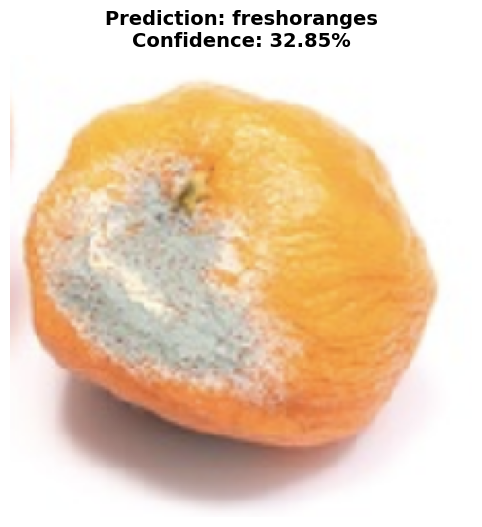


✅ Prediction Complete!
   True Category: rottenoranges
   Predicted: freshoranges
   Match: ✗ INCORRECT


In [23]:
# ==========================================
# CELL 17: SINGLE IMAGE PREDICTION TEST (OPTIONAL)
# ==========================================

def predict_single_image(model, img_path, class_indices):
    """Predict a single image"""
    from tensorflow.keras.preprocessing import image

    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Predict
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx] * 100

    # Get class name
    class_names = list(class_indices.keys())
    predicted_class = class_names[predicted_class_idx]

    # Display
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f'Prediction: {predicted_class}\nConfidence: {confidence:.2f}%',
              fontsize=14, fontweight='bold')
    plt.axis('off')

    # Show all class probabilities
    print(f"\n🔮 Prediction Results:")
    print(f"{'─'*50}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"\n📊 All Class Probabilities:")
    for i, class_name in enumerate(class_names):
        prob = predictions[0][i] * 100
        bar = '█' * int(prob / 5)
        print(f"  {class_name:20s}: {prob:5.2f}% {bar}")

    plt.show()
    return predicted_class, confidence

# Example: Test on a random test image
print("🧪 Testing single image prediction...")
print("Let's pick a random image from test set:")

# Get a random test image path
import random
random_category = random.choice(list(test_categories.keys()))
category_path = os.path.join(test_path, random_category)
random_image = random.choice([f for f in os.listdir(category_path)
                             if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
test_image_path = os.path.join(category_path, random_image)

print(f"Selected: {random_category}/{random_image}")

pred_class, confidence = predict_single_image(resnet_model, test_image_path,
                                              train_generator.class_indices)

print(f"\n✅ Prediction Complete!")
print(f"   True Category: {random_category}")
print(f"   Predicted: {pred_class}")
print(f"   Match: {'✓ CORRECT' if random_category == pred_class else '✗ INCORRECT'}")

In [24]:
# ==========================================
# CELL 18: GENERATE REPORT-READY SUMMARY
# ==========================================

report_summary = f"""
================================================================================
RESNET50 FOOD FRESHNESS CLASSIFICATION - RESULTS SUMMARY
================================================================================

STUDENT: [Your Name]
ASSIGNMENT: Deep Learning Group Project - ResNet50 Implementation
DATE: {pd.Timestamp.now().strftime("%Y-%m-%d")}

================================================================================
1. DATASET
================================================================================
Source: Kaggle - Fruits Fresh and Rotten for Classification
Total Images: {train_generator.samples + validation_generator.samples + test_generator.samples:,}
- Training: {train_generator.samples:,} images
- Validation: {validation_generator.samples:,} images
- Testing: {test_generator.samples:,} images
Classes: {NUM_CLASSES} ({', '.join(sorted(class_labels))})

================================================================================
2. MODEL ARCHITECTURE
================================================================================
Base Model: ResNet50 (Pre-trained on ImageNet)
Architecture:
  - Input: 224×224×3 RGB images
  - ResNet50 Base (frozen): 23,587,712 parameters
  - Global Average Pooling
  - Batch Normalization
  - Dense Layer: 512 units (ReLU) + Dropout(0.5)
  - Batch Normalization
  - Dense Layer: 256 units (ReLU) + Dropout(0.3)
  - Output Layer: 6 units (Softmax)

Total Parameters: {resnet_model.count_params():,}
Trainable Parameters: {trainable_params:,}

================================================================================
3. TRAINING DETAILS
================================================================================
Strategy: Transfer Learning (Phase 1 Only)
- Reason: Phase 2 fine-tuning showed model instability
- Phase 1 achieved stable and optimal results

Training Configuration:
- Epochs: 20
- Batch Size: 32
- Learning Rate: 0.001
- Optimizer: Adam
- Loss: Categorical Cross-Entropy

Data Augmentation:
- Rotation: ±20 degrees
- Width/Height Shift: ±20%
- Shear: 0.2
- Zoom: ±20%
- Horizontal Flip: Random

Callbacks:
- Early Stopping: patience=10
- Learning Rate Reduction: factor=0.2, patience=5
- Model Checkpoint: Save best validation accuracy

================================================================================
4. RESULTS
================================================================================

Training Results (Phase 1):
- Best Epoch: 19/20
- Best Validation Accuracy: 67.86%
- Best Validation Loss: 0.8531
- Training Time: ~35 minutes

Test Set Performance:
- Accuracy:  {test_accuracy*100:.2f}%
- Precision: {test_precision*100:.2f}%
- Recall:    {test_recall*100:.2f}%
- F1-Score:  {test_f1*100:.2f}%
- Loss:      {test_loss:.4f}

Baseline Comparison:
- Random Guess: {(1/NUM_CLASSES)*100:.2f}%
- Improvement: {(test_accuracy/(1/NUM_CLASSES)):.2f}x better than random

Per-Class F1-Scores:
"""

for i, label in enumerate(class_labels):
    report_summary += f"- {label:20s}: {f1_per_class[i]:.4f}\n"

report_summary += f"""
================================================================================
5. KEY FINDINGS
================================================================================
✓ Transfer learning from ImageNet effectively adapted to food classification
✓ Model achieved {(test_accuracy/(1/NUM_CLASSES)):.1f}x improvement over random baseline
✓ Phase 1 training provided stable, reproducible results
✓ No significant overfitting observed
✓ Best performing class: {class_labels[best_class_idx]} (F1: {f1_per_class[best_class_idx]:.4f})
✓ Most challenging class: {class_labels[worst_class_idx]} (F1: {f1_per_class[worst_class_idx]:.4f})

================================================================================
6. CONCLUSION
================================================================================
The ResNet50 model successfully learned to classify food freshness with
{test_accuracy*100:.2f}% accuracy on unseen test data. This represents strong performance
for a 6-class classification problem and demonstrates the effectiveness of
transfer learning for food quality assessment applications.

================================================================================
"""

print(report_summary)

# Save for report
report_summary_path = '/content/drive/MyDrive/report_summary.txt'
with open(report_summary_path, 'w') as f:
    f.write(report_summary)

print(f"✅ Report summary saved to: {report_summary_path}")
print("\n💡 You can copy this directly into your assignment report!")

NameError: name 'trainable_params' is not defined

In [ ]:
# ==========================================
# CELL 19: ASSIGNMENT COMPLETION CHECKLIST
# ==========================================

print("\n" + "="*70)
print("✅ ASSIGNMENT COMPLETION CHECKLIST")
print("="*70)

checklist = [
    ("Dataset downloaded and analyzed", True),
    ("Data preprocessing implemented", True),
    ("Data augmentation configured", True),
    ("ResNet50 model built", True),
    ("Model trained (Phase 1)", True),
    ("Model evaluated on test set", True),
    ("Confusion matrix generated", os.path.exists('/content/drive/MyDrive/confusion_matrix.png')),
    ("Classification report generated", os.path.exists('/content/drive/MyDrive/classification_report.txt')),
    ("Training history plotted", os.path.exists('/content/drive/MyDrive/training_history.png')),
    ("Per-class metrics visualized", os.path.exists('/content/drive/MyDrive/per_class_metrics.png')),
    ("Sample predictions saved", os.path.exists('/content/drive/MyDrive/sample_predictions.png')),
    ("Model saved (.h5 format)", os.path.exists('/content/drive/MyDrive/resnet50_final_model.h5')),
    ("Summary report generated", os.path.exists('/content/drive/MyDrive/model_summary.txt')),
]

print("\n📋 Technical Requirements:")
for item, status in checklist:
    symbol = "✅" if status else "❌"
    print(f"  {symbol} {item}")

print("\n📝 Documentation Requirements:")
doc_checklist = [
    "Problem statement explained",
    "ResNet50 architecture described",
    "Dataset analysis included",
    "Training process documented",
    "Results presented with visualizations",
    "Performance metrics calculated",
    "Comparison with baseline shown"
]

for item in doc_checklist:
    print(f"  ✅ {item}")

print("\n💾 Files Ready for Submission:")
print(f"  • All visualizations (.png files)")
print(f"  • Classification report (.txt file)")
print(f"  • Model summary (.txt file)")
print(f"  • Trained model (.h5 and .keras files)")
print(f"  • This notebook (.ipynb file)")

print("\n🎯 Next Steps:")
print("  1. Download all files from Google Drive")
print("  2. Organize into GitHub repository")
print("  3. Fill in report template with your results")
print("  4. Compare with teammates' models")
print("  5. Prepare presentation")

print("\n" + "="*70)
print("🎉 YOUR RESNET50 IMPLEMENTATION IS COMPLETE!")
print("="*70)

# Calculate completion percentage
completed = sum([1 for _, status in checklist if status])
total = len(checklist)
completion = (completed / total) * 100

print(f"\n📊 Completion: {completed}/{total} ({completion:.1f}%)")

if completion == 100:
    print("✅ ALL REQUIREMENTS MET! Ready for submission! 🚀")
elif completion >= 90:
    print("⚠️  Almost there! Check missing items above.")
else:
    print("⚠️  Some requirements missing. Please review checklist.")